In [ ]:
import cupy as cp
import numpy as np
from decorrelation.shp import ks_2sam
from matplotlib import pyplot as plt

In [ ]:
rslc = cp.load('./rslc.npy')
rslc = rslc[700:800,0:100,:]

In [ ]:
# here rslc is nlines*width*nimage

In [ ]:
rslc.shape

(100, 100, 17)

In [ ]:
rmli = cp.abs(rslc)**2

In [ ]:
az_half_win = 5
r_half_win = 5
az_index = np.arange(az_half_win,rslc.shape[0]-az_half_win,dtype=int)
r_index = np.arange(r_half_win,rslc.shape[1]-az_half_win,dtype=int)
az_win_index = np.arange(-az_half_win,az_half_win+1,dtype=int)
r_win_index = np.arange(-r_half_win,r_half_win+1,dtype=int)

In [ ]:
r_win_index

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5])

In [ ]:
# az_index, range_index, az_shift, range_shift
a = np.meshgrid(az_index,r_index,az_win_index,r_win_index)
a = np.stack(a)

In [ ]:
a.shape

(4, 90, 90, 11, 11)

In [ ]:
# first 0 means return az_index, index of az_index, index of range_index,
shp_table_shape = a[0,:,:,:,:].shape
a[0,:,:,:,:].reshape(-1)

array([ 5,  5,  5, ..., 94, 94, 94])

In [ ]:
sorted_rmli = cp.sort(rmli,axis=-1)
ref_shp_stack = sorted_rmli[a[0,:,:,:,:].reshape(-1),a[1,:,:,:,:].reshape(-1)]
sec_shp_stack = sorted_rmli[(a[0,:,:,:,:]+a[2,:,:,:,:]).reshape(-1),(a[1,:,:,:,:]+a[3,:,:,:,:]).reshape(-1)]

In [ ]:
ref_shp_stack.shape

(980100, 17)

In [ ]:
sec_shp_stack.shape

(980100, 17)

In [ ]:
is_shp_stack = ks_2sam(ref_shp_stack,sec_shp_stack,0.5)

In [ ]:
is_shp_stack

array([False, False, False, ..., False, False, False])

In [ ]:
is_shp_dense = is_shp_stack.reshape(shp_table_shape)

In [ ]:
is_shp_dense.shape

(90, 90, 11, 11)

In [ ]:
is_shp_dense.reshape(*is_shp_dense.shape[0:-2],-1).shape

(90, 90, 121)

In [ ]:
shp_number_thres = 2
num_shp = is_shp_dense.reshape(*is_shp_dense.shape[0:-2],-1).sum(axis=-1)
num_shp.shape
# select base on number of num_shp

(90, 90)

In [ ]:
num_shp

array([[ 6,  1,  1, ..., 33, 54, 12],
       [ 7,  3,  3, ..., 45, 37, 46],
       [ 3, 19, 20, ..., 46, 29, 51],
       ...,
       [ 5, 31, 14, ..., 55, 27, 34],
       [17, 21, 34, ..., 25, 17, 35],
       [ 2,  8,  5, ..., 44, 35,  5]])

In [ ]:
rslc_0 = rslc[a[0,:,:,:,:].reshape(-1),a[1,:,:,:,:].reshape(-1),0].reshape(*shp_table_shape[0:-2],-1)
rslc_1 = rslc[(a[0,:,:,:,:]+a[2,:,:,:,:]).reshape(-1),(a[1,:,:,:,:]+a[3,:,:,:,:]).reshape(-1),1].reshape(*shp_table_shape[0:-2],-1)
rslc_1 = rslc_1*is_shp_dense.reshape(*is_shp_dense.shape[0:-2],-1) # set non-shp as zero
diff = cp.sum(rslc_0*rslc_1.conj(),axis=-1)

In [ ]:
diff.shape

(90, 90)

In [ ]:
def bg_alpha(pwr):
    _pwr = np.power(pwr,0.35)
    cv = _pwr.mean()*2.5
    v = (_pwr.clip(0., cv))/cv
    return v

<matplotlib.colorbar.Colorbar>

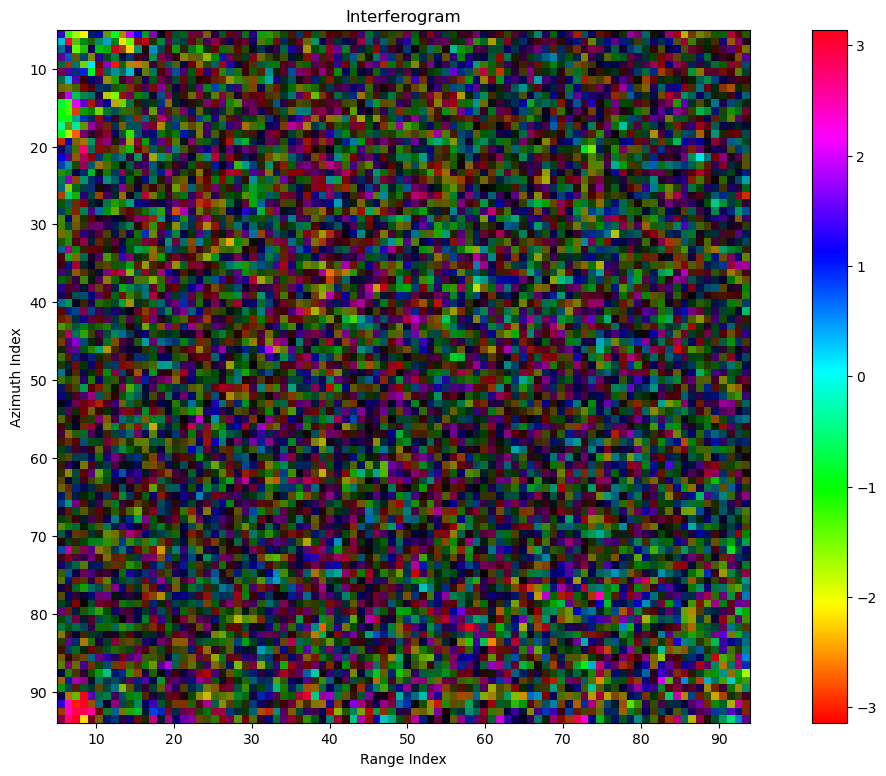

In [ ]:
plot_bg = rmli[a[0,:,:,0,0].reshape(-1),a[1,:,:,0,0].reshape(-1),0].reshape(*shp_table_shape[0:-2])
plot_bg = cp.asnumpy(plot_bg)
plot_data = cp.asnumpy(cp.angle(diff))

extent = (np.min(r_index), np.max(r_index), np.max(az_index), np.min(az_index))

alpha = bg_alpha(plot_bg)

fig,ax = plt.subplots(1,1,figsize=(16,9))
xlabel = 'Range Index'
ylabel = 'Azimuth Index'
pcm0 = ax.imshow(plot_data,alpha=alpha,interpolation='nearest',cmap='hsv',extent=extent)
# the real image showed is alpha*rgb + (1-alpha)*facecolor
ax.set(facecolor = "black")
ax.set(title='Interferogram',xlabel=xlabel,ylabel=ylabel)
fig.colorbar(pcm0,ax=ax)